In Part 4, we'll reduce dimensionality of our dataset transforming features to principal components.

We'll do so to achieve 2 goals:

-) Avoid possible overfitting

-) Reduce the runtime for testing and hyperparameters tuning

Let's load our datasets from Part_3:

In [80]:
%%time

import pandas as pd
import numpy as np


global_variables = pd.read_csv('global_variables.csv', index_col=0)
SEED = global_variables.loc[0, 'SEED']
N_SPLITS = global_variables.loc[0, 'N_SPLITS']

train_from_part_3 = pd.read_csv('new_datasets/train_from_part_3.csv', index_col='ID_LAT_LON_YEAR_WEEK')
test_from_part_3 = pd.read_csv('new_datasets/test_from_part_3.csv', index_col='ID_LAT_LON_YEAR_WEEK')
post_training_df = pd.read_csv('new_datasets/post_training_df.csv', index_col='ID_LAT_LON_YEAR_WEEK')

top_three_values = train_from_part_3.loc[:, 'Location_enc'].drop_duplicates().sort_values(ascending = False).head(3)
top_three_locations = train_from_part_3.loc[train_from_part_3['Location_enc'].isin(top_three_values), 'Location'].drop_duplicates()


CPU times: total: 1.36 s
Wall time: 1.42 s


We'll create an elbow plot of explained variance by number of principal components:

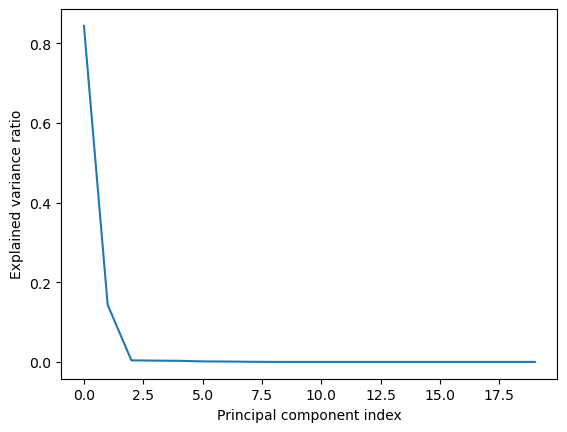

CPU times: total: 1.8 s
Wall time: 520 ms


In [81]:
%%time

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train = train_from_part_3.drop(['Location', 'date', 'emission_04'], axis=1)

pca = PCA(n_components = 20)

# Fit PCA
pca.fit(X_train)

# Plot the explained variance ratio
plt.plot(pca.explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

## 00. Baseline. 2 PC

Interestingly, most of variance is explained just by 2 principal components. Let's tranform our features into 2 components:

In [82]:
%%time

study_number = '00'

pca = PCA(n_components = 2)

X_train = pca.fit_transform(X_train)

train = pd.concat([pd.DataFrame(X_train, index=train_from_part_3.index, columns=['PC1', 'PC2']),
                   train_from_part_3['emission_04']], axis=1)
                   
X_test = test_from_part_3.drop(['Location', 'date'], axis=1)

X_test = pca.transform(X_test)

test = pd.DataFrame(X_test, index=test_from_part_3.index, columns=['PC1', 'PC2'])

train.head()

CPU times: total: 938 ms
Wall time: 309 ms


,PC1,PC2,emission_04
ID_LAT_LON_YEAR_WEEK,,,
ID_-0.510_29.290_2019_00,-1881.655683,-3605.984212,0.000000
ID_-0.510_29.290_2019_01,-13115.664053,552.725609,0.158000
ID_-0.510_29.290_2019_02,-2665.646169,-497.164566,0.255728
ID_-0.510_29.290_2019_03,11716.264908,11427.623616,0.129001
ID_-0.510_29.290_2019_04,-8075.549329,-3048.982659,0.076215


In [83]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 79023 entries, ID_-0.510_29.290_2019_00 to ID_-3.299_30.301_2021_52
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          79023 non-null  float64
 1   PC2          79023 non-null  float64
 2   emission_04  79023 non-null  float64
dtypes: float64(3)
memory usage: 2.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, ID_-0.510_29.290_2022_00 to ID_-3.299_30.301_2022_48
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     24353 non-null  float64
 1   PC2     24353 non-null  float64
dtypes: float64(2)
memory usage: 570.8+ KB
None


Now, let's test the performance of LightGBM on this dataset. We'll increase the number of estimators, since after the dimensionality reduction our model will train much faster:

In [84]:
%%time

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test RMSE': []})

# Instantiate the estimator
# UNCOMMENT TO INSTALL LightGBM
#!pip install lightgbm
import lightgbm as lgb

model = lgb.LGBMRegressor(random_state=SEED, n_jobs=-1, n_estimators=5)

# Calculate scores
from functions.get_score_3 import get_score_3

train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train, test, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="Part 4 Baseline")

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

CPU times: total: 2.7 s
Wall time: 307 ms


In [85]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 4 Baseline,27.154261,34.734932,33.38582


Indeed, we scored almost as good as our best score.

## 01. Linear Regression

Let's try another estimator:

In [86]:
%%time

study_number = '01'

from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=-1)

# Calculate scores
from functions.get_score_3 import get_score_3

train_score, cross_score, cross_scores_std, submission = get_score_3(global_variables, train, test, 
                                                                     post_training_df, model, scores_df,
                                                                  comment="Linear Regression")

submission.to_csv('submissions/submission_4_' + study_number + '.csv', index=False)

CPU times: total: 484 ms
Wall time: 190 ms


In [87]:
scores_df.loc[int(study_number), 'Test RMSE'] = np.nan
scores_df

,Comment,Train Score,Cross-val Score,Test RMSE
0,Part 4 Baseline,27.154261,34.734932,33.38582
1,Linear Regression,27.134326,34.733733,NaN


## Target standartization

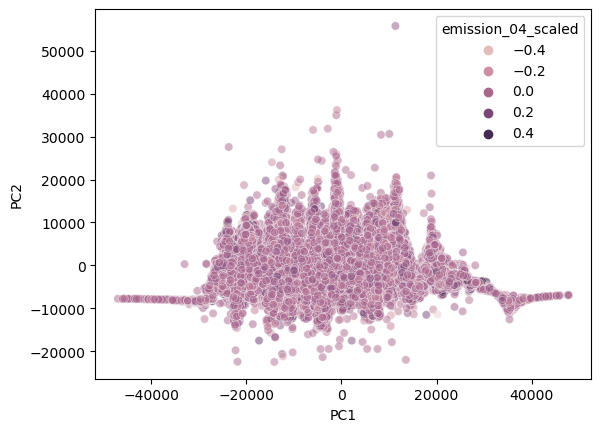

CPU times: total: 2.41 s
Wall time: 2.49 s


count    7.902300e+04
mean    -4.889179e-19
std      1.000006e+00
min     -6.495536e+01
25%     -4.443940e-02
50%     -1.721286e-03
75%      4.648566e-02
max      8.299318e+01
Name: emission_04_scaled, dtype: float64

In [94]:
%%time

from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()

train['emission_04_scaled'] = scaler.fit_transform(train[['emission_04']])

sns.scatterplot(data=train[abs(train['emission_04_scaled']) < 0.5], x='PC1', y='PC2', hue='emission_04_scaled', alpha=0.5)
plt.show()

train['emission_04_scaled'].describe()